# Goals  for this notebook: #

### Try to measure the quality of the two classifiers (simple logistic regression and KMeans augmented log reg) by using the distributions of the scores for the data-points of each single class ###


We try to measure the quality of the two classifiers (simple logistic regression and KMeans augmented log reg) by using the distributions of the scores for the data-points of each single class (i.e. the distribution of the probability-values between 0 and 1 delivered by the logistic-regression  ... which is where the threshold for ROC etc. lives...). And compare this to ROC/ PRC analysis.

Findings:
1. There is improvement over plain logistic regression: 0.983 vs. 0.975
2. the comparison of the distribution of the probability-mass for the respective classes is more spread-out for the log_reg classifier: 
    1. the mean of the probabilities is lower, i.e. more smal probabilities are assigned
    2. the variance of the probabilities is higher, i.e. there are more instances with low value

That is, the classifier log_reg is worse than the pipeline, since we expect a good classifier to be sure about it's assignments (i.e. have probability-values close to one for each instance) and to have very few instances with assignments considerably less than one (i.e. low variance (?)). <br>
Maybe the last point could be better measured by a comparison of the mean and the median like this: "mean close to median" == "concentrated distribution" (of course we want "mean close to one" in addition).
<br>
The idea to use the distributions of the class-probabilites returned by the classifier was inspired by the discussion of ROC vs PRC here:

https://towardsdatascience.com/demystifying-roc-curves-df809474529a

<br>
The idea behind this is the observation, that what we do with "true positive rate", "precision" etc. is to describe a distribution, namely the distribution of the probability values asigned by a classifier, by moving a threshold up and down the axis. That might be usefull for clinical tests etc. but not necessarily for machine-learning.

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

X_digits, y_digits = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2)

In [2]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, tol=0.04)
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.9805555555555555

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

nof_clusters = 100
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=nof_clusters)),
    #("log_reg", LogisticRegression()),
    ("log_reg", LogisticRegression(tol=0.4, max_iter=10000))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9722222222222222

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
#    ("scaler", StandardScaler()),
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression(tol=0.4, max_iter=1000)),
])

param_grid = {
    "kmeans__n_clusters" : range(2,101)
    }
grid_clf= GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)


Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=1000,
                                                           tol=0.4))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(2, 101)},
             verbose=2)

In [5]:
grid_clf.best_params_, grid_clf.score(X_test, y_test)

({'kmeans__n_clusters': 69}, 0.9722222222222222)

Analyse the quality of the classifier:

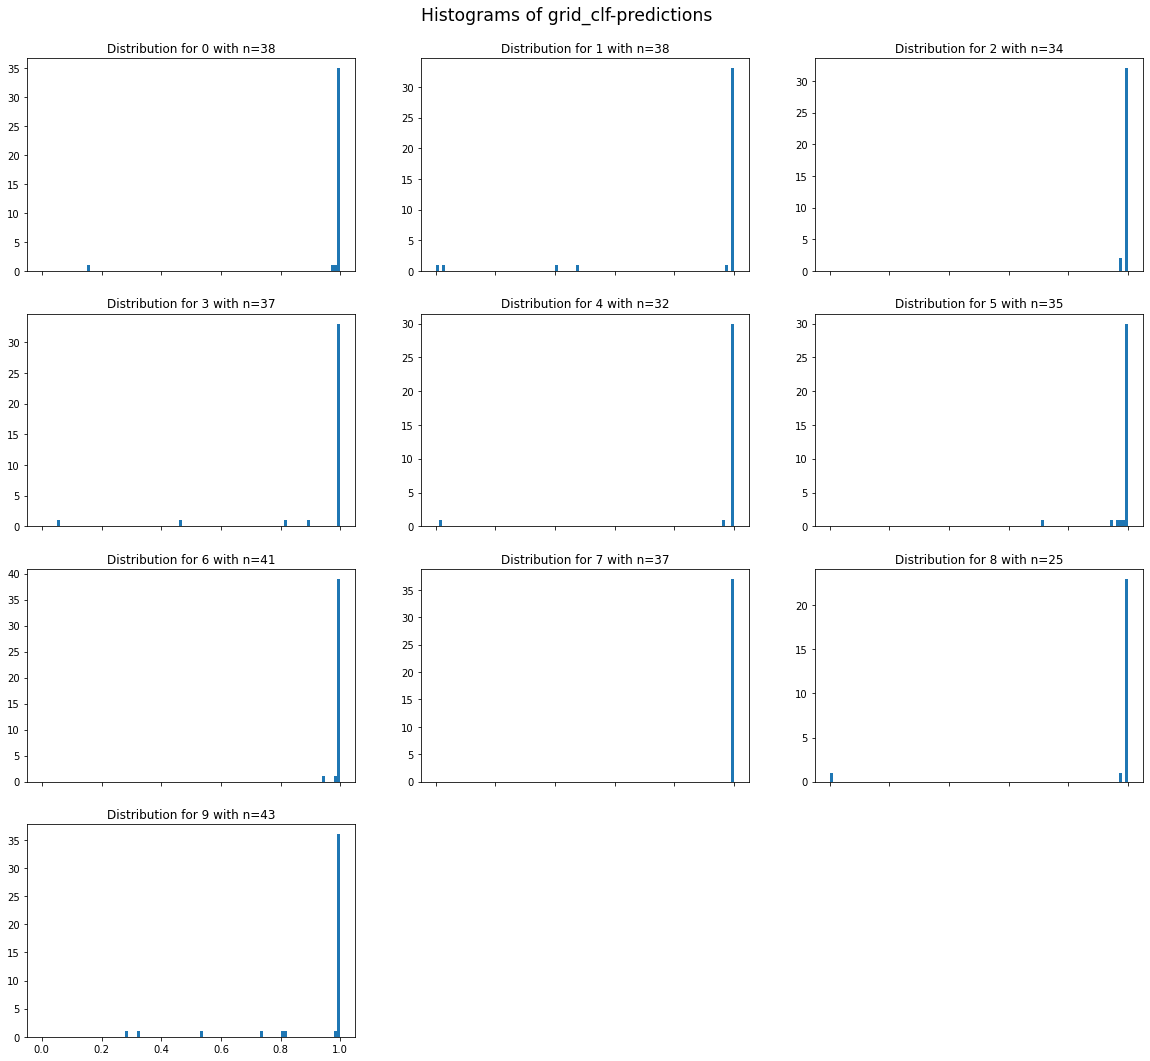

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

#switch = "log_reg"
switch = "grid_clf"
nof_classes = 10 # number of classes/labels
nof_diagram_columns = 3
nof_diagram_rows = 4
fig_width = 20 # drawing-area hight
fig_height = 18 # drawing-area width


fig, axs = plt.subplots(nof_diagram_rows,nof_diagram_columns, figsize=(fig_width,fig_height), sharex=True)
fig.suptitle(f"Histograms of {switch}-predictions", size='xx-large', y=0.92)

stats = np.zeros((nof_classes,2)) # contains the values for mean and var for each class
p_is = []
r = 0
c = 0

for i in range(nof_classes):
    i_mask = y_test == i
    Xi_test = X_test[i_mask] # get the data-point with label i

    if switch == "grid_clf":
        p_i = grid_clf.predict_proba(Xi_test)
    elif switch == "log_reg":
        p_i = log_reg.predict_proba(Xi_test)

    pi_is_i = np.array([ b[i] for b in p_i])
    p_i_sorted = np.sort(pi_is_i)
    p_is.append(p_i_sorted)
    stats[i, 0] = np.mean(pi_is_i)
    stats[i, 1] = np.var(pi_is_i)

    i_counts, i_bins = np.histogram(p_i_sorted, bins=100, range=(0,1))
    if len(axs.shape) > 1:
        axs[r, c].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r, c].set_title(f"Distribution for {i} with n={len(p_is[i])}")

        if c < nof_diagram_columns-1:
            c += 1
        else:
            r += 1
            c = 0
    else:
        axs[r].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r].set_title(f"Probability mass allocation for {i} with n={len(p_is[i])}")
        r += 1

axs[3,1].remove()
axs[3,2].remove()


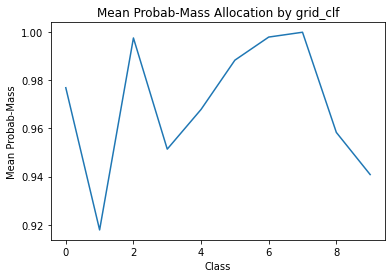

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
xs=np.arange(nof_classes)
ys=stats[:,0] # mean probability-mass allocation per class
ax.set_xlabel("Class")
ax.set_ylabel("Mean Probab-Mass")
ax.set_title(f"Mean Probab-Mass Allocation by {switch}")
ax.plot(xs, ys) 

The figure of the "Mean-Probab-Mass Allocation" shows clearly, which classes are problematic because their members do not get enough probability-mass allocated, i.e. are miss-classified (the mass is given to other classes i.e. wrongly allocated).

In [ ]:
# statistics of probabvalues: mean, variance:
s = np.sum(stats, axis=0)

if switch == "grid_clf":
    print(f"Sum of probabilities: {s[0]} and variances: {s[1]} assigned by grid-classifier.")
elif switch == "log_reg":
    print(f"Sum of probabilities: {s[0]} and variances: {s[1]} assigned by log_reg-classifier.")
# result:
# Sum of probabilities: 9.5623238455677 and variances: 0.3043238373361892  assigned by log_reg-classifier.
# Sum of probabilities: 9.675666433618208 and variances: 0.18160522944854848 assigned by grid-classifier.

In [34]:
# statistics of probabvalues: mean, variance:
m = np.mean(stats, axis=0)

if switch == "grid_clf":
    print(f"Mean of probabilities: {m[0]} and variances: {m[1]} assigned by grid-classifier.")
elif switch == "log_reg":
    print(f"Mean of probabilities: {m[0]} and variances: {m[1]} assigned by log_reg-classifier.")

# result:
# Mean of probabilities: 0.9526218498645296 and variances: 0.030432383733618916 assigned by log_reg-classifier.
# Mean of probabilities: 0.9675666433618207 and variances: 0.01816052294485485 assigned by grid-classifier.

Mean of probabilities: 0.9526218498645296 and variances: 0.030432383733618916 assigned by log_reg-classifier.


So we see, that the log_reg classifier has 0.952 of all probability-mass assigned to the right data-points, while the grid_classifier has 0.967. <br>
At the same time, the variance of the log-reg mass-distribution is more spread out, 0.030, than the grid_classifiers with a mean-variance of 0.0182. <br>
<br>
My conclusion would be, that the grid_classifier is a better classifier. <br>
Let's see, what ROC has to say about this.

In [ ]:
from sklearn import metrics

y_pred = log_reg.predict_proba(Xi_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred) # this does not work, because scikit does not do ova her. Maybe numpy?

Summary:

the comparison of the distribution of the probability-mass for the respective classes is more spread-out for the log_reg classifier: 
1. the mean of the probabilities is lower, i.e. more smal probabilities are assigned
2. the variance of the probabilities is higher, i.e. there are more instances with low value

That is, the classifier log_reg is worse than the pipeline, since we expect a good classifier to be sure about it's assignments (i.e. have mean probability close to one for each instance) and to have very few instances with assignments considerably less than one (low variance). Maybe the last point could be better measured by a comparison of the mean and the median like this: "mean close to median" == "concentrated distribution" (of course we want "mean close to one" in addition).